In [13]:
%cd ..
import numpy as np
import cv2
import os
import torch
import torchvision


import matplotlib.pyplot as plt
import plyfile
import open3d as o3d
import blenderpy as bpy

import utils.uv
%load_ext autoreload
%autoreload 2

/Users/alexkristoffersen/Desktop/cs184/final_project
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def spherical_sample_fn(x):
    '''
    Converts an x value to an rgb color based off of its normal

    Args:
        x: (N, 3)
    Returns:
        col: (N, 3), [0, 1] rgb
    '''
    x = np.abs(x) / np.linalg.norm(x)
    return x


def normuv(uv, H, W):
    """
    Normalize pixel coordinates to lie in [-1, 1]
    
    :param uv (..., 2) unnormalized pixel coordinates for HxW image
    """
    u = uv[..., 0] / H * 2.0 - 1.0
    v = uv[..., 1] / W * 2.0 - 1.0
    return torch.stack([u, v], dim=-1)


def unnormuv(uv, H, W):
    """
    Un-normalize pixel coordinates
    
    :param uv (..., 2) normalized pixel coordinates in [-1, 1]
    """
    u = (uv[..., 0] + 1.0) / 2.0 * H
    v = (uv[..., 1] + 1.0) / 2.0 * W
    return torch.stack([u, v], dim=-1)
    

def get_uv(H, W):
    """
    Get normalized uv coordinates for image
    :param height (int) source image height
    :param width (int) source image width
    :return uv (N, 2) pixel coordinates in [-1.0, 1.0]
    """
    yy, xx = torch.meshgrid(
        (torch.arange(H, dtype=torch.float32) + 0.5),
        (torch.arange(W, dtype=torch.float32) + 0.5),
        indexing='ij',
    )
    uv = torch.stack([xx, yy], dim=-1) # (H, W, 2)
    uv = normuv(uv, W, H) # (H, W, 2)
    return uv.view(H * W, 2)


def create_spherical_uv_sampling(im_shape):
    '''
    creates the sampling of directions from the origin around 360 space.
    Args:
        im_shape: (H, W)
    Returns:
        uv sampling map (H, W)
    '''
    H, W = im_shape
    phis_thetas = get_uv(H, W).numpy() * [np.pi, 2 * np.pi] # phi, theta
    uv_directions = np.column_stack(
        [
            np.sin(phis_thetas[:, 0]) * np.cos(phis_thetas[:, 1]),
            np.sin(phis_thetas[:, 0]) * np.sin(phis_thetas[:, 1]),
            np.cos(phis_thetas[:, 0]),
        ],
    )
    return uv_directions


In [15]:
def get_spherical_coords(X):
    # X is N x 3
    rad = np.linalg.norm(X, axis=1)
    # Inclination
    theta = np.arccos(X[:, 2] / rad)
    # Azimuth
    phi = np.arctan2(X[:, 1], X[:, 0])

    # Normalize both to be between [-1, 1]
    vv = (theta / np.pi) * 2 - 1
    uu = ((phi + np.pi) / (2*np.pi)) * 2 - 1
    # Return N x 2
    return np.stack([uu, vv],1)

In [16]:
def triangle_direction_intersection(tri, trg):
    '''
    Finds where an origin-centered ray going in direction trg intersects a triangle.
    Args:
        tri: 3 X 3 vertex locations. tri[0, :] is 0th vertex.
    Returns:
        alpha, beta, gamma
    '''
    p0 = np.copy(tri[0, :])
    # Don't normalize
    d1 = np.copy(tri[1, :]) - p0
    d2 = np.copy(tri[2, :]) - p0
    d = trg / np.linalg.norm(trg)

    mat = np.stack([d1, d2, d], axis=1)

    try:
      inv_mat = np.linalg.inv(mat)
    except np.linalg.LinAlgError:
      return False, 0
    
    a_b_mg = -1*np.matmul(inv_mat, p0)
    is_valid = (a_b_mg[0] >= 0) and (a_b_mg[1] >= 0) and ((a_b_mg[0] + a_b_mg[1]) <= 1) and (a_b_mg[2] < 0)
    if is_valid:
        return True, -a_b_mg[2]*d
    else:
        return False, 0

In [17]:
def mesh_centroid(vertices, faces):

    return np.average(vertices, axis=0)

def create_spherical_uv_map(H, W, vertices, faces, sample_fn=spherical_sample_fn):
    ray_dirs = create_spherical_uv_sampling((H, W)) # (H * W, 3)
    mesh_center = mesh_centroid(vertices, faces)

    normalized_vertices = vertices - mesh_center
    uv_map = np.zeros((H, W, 3))

    for face in faces:
        pass

    return uv_map

In [18]:
mesh_centroid(
    np.array(
        [
            [1, 1, 1],
            [1, 1, -1],
            [1, -1, -1],
            [1, -1, 1],
            [-1, 1, 1],
            [-1, 1, -1],
            [-1, -1, -1],
            [-1, -1, 1],
        ],
    ),
    np.array(
        [
            [0, 1, 2],
            [0, 2, 3],
            [1, 5, 2],
            [2, 5, 6],
            [3, 2, 6],
            [3, 6, 7],
            [4, 5, 1],
            [4, 1, 0],
            [4, 0, 3],
            [4, 3, 7],
            [4, 5, 6],
            [4, 6, 7],
        ]
    ),
)

array([0., 0., 0.])

In [19]:
get_uv(5, 5).shape

torch.Size([25, 2])

In [20]:
def numpy_to_ply(vertices, faces, vert_colors=None, filename=None):
    '''
    Converts numpy arrays to PLY file, which can be used
    in blender or converted into an obj file.
    Args:
        # vertices: (|V|, 3), <x,y,z>
        # faces: (|F|, 3), vertex indices, 3 for each triangle
        # vert_colors (optional): (|V|, 3) RGB, [0, 1] range
        # filename: string. if not None, write to given filepath.
    Returns:
        PlyData obj
    '''
    assert vertices.shape[1] == 3 and faces.shape[1] == 3

    if vert_colors is None:
        vertices = np.array(
            [tuple(vertices[i]) for i in range(vertices.shape[0])],
            dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')],
        )
    else:
        vertices = np.array(
            [(*vertices[i], vert_colors[i, 0], vert_colors[i, 1], vert_colors[i, 2])  
              for i in range(vertices.shape[0])],
            dtype=[
                ('x', 'f4'), ('y', 'f4'), ('z', 'f4'), 
                ("red", "u1"), ("green", "u1"), ("blue", "u1"),
            ],
        )
    faces = np.array(
        [tuple([faces[i]]) for i in range(faces.shape[0])],
        dtype=[('vertex_indices', 'i4', (3,))],
    )
    ply_data = plyfile.PlyData(
        [
            plyfile.PlyElement.describe(
                vertices, 
                'vertex',
                comments=['model vertices'],
            ),
            plyfile.PlyElement.describe(
                faces,
                'face',
            ),
        ],
    )
    if filename:
        ply_data.write(filename)
    
    return ply_data


In [21]:
unit_box_vertices = np.array(
    [
        [1, 1, 1],
        [1, 1, -1],
        [1, -1, -1],
        [1, -1, 1],
        [-1, 1, 1],
        [-1, 1, -1],
        [-1, -1, -1],
        [-1, -1, 1],
    ],
)

unit_box_faces = np.array(
    [
        [0, 1, 2],
        [0, 2, 3],
        [1, 5, 2],
        [2, 5, 6],
        [3, 2, 6],
        [3, 6, 7],
        [4, 5, 1],
        [4, 1, 0],
        [4, 0, 3],
        [4, 3, 7],
        [4, 5, 6],
        [4, 6, 7],
    ]
)

unit_box_vertex_colors = (255 * (unit_box_vertices + 1) / 2.0).astype(np.uint8)


In [22]:
numpy_to_ply(
    unit_box_vertices, 
    unit_box_faces, 
    vert_colors=unit_box_vertex_colors,
    filename="test.ply",
)

PlyData((PlyElement('vertex', (PlyProperty('x', 'float'), PlyProperty('y', 'float'), PlyProperty('z', 'float'), PlyProperty('red', 'uchar'), PlyProperty('green', 'uchar'), PlyProperty('blue', 'uchar')), count=8, comments=['model vertices']), PlyElement('face', (PlyListProperty('vertex_indices', 'uchar', 'int'),), count=12, comments=[])), text=False, byte_order='<', comments=[], obj_info=[])

In [86]:
test_uv = np.load("Scene2Mesh/test_uv_map.npy", allow_pickle=True)[()]

In [91]:
test_uv

{0: {0: (0.0020020019728690386, 0.3323323428630829),
  1: (0.3323323428630829, 0.3323323428630829),
  2: (0.3323323428630829, 0.0020020019728690386)},
 1: {0: (0.3323323428630829, 0.3353353440761566),
  2: (0.0020020019728690386, 0.6656656861305237),
  3: (0.3323323428630829, 0.6656656861305237)},
 2: {1: (0.6656656861305237, 0.3323323428630829),
  5: (0.3353353440761566, 0.3323323428630829),
  2: (0.6656656861305237, 0.0020020019728690386)},
 3: {2: (0.6656656861305237, 0.3353353440761566),
  5: (0.3353353440761566, 0.6656656861305237),
  6: (0.6656656861305237, 0.6656656861305237)},
 4: {3: (0.0020020019728690386, 0.9989989995956421),
  2: (0.3323323428630829, 0.9989989995956421),
  6: (0.3323323428630829, 0.6686686873435974)},
 5: {3: (0.9989989995956421, 0.0020020019728690386),
  6: (0.6686686873435974, 0.3323323428630829),
  7: (0.9989989995956421, 0.3323323428630829)},
 6: {4: (0.9979979991912842, 0.0010010009864345193),
  5: (0.6676676869392395, 0.0010010009864345193),
  1: (0.6

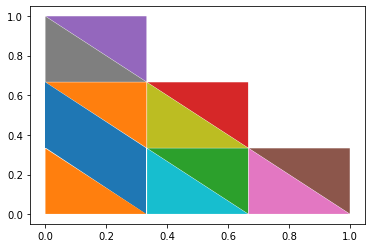

In [87]:
for i in range(12):
    keys = sorted(test_uv[i].keys())
    xs = [test_uv[i][k][0] for k in keys]
    ys = [test_uv[i][k][1] for k in keys]
    plt.fill(xs, ys)

In [180]:
texture_im = utils.uv.draw_texture_map(
    128, 
    128, 
    unit_box_vertices, 
    test_uv, 
    # sample_fn= red_top # lambda x: np.ones((x.shape[0], 3)),
)

0
v_positions: [[ 1  1  1]
 [ 1  1 -1]
 [ 1 -1 -1]]
uv_locs: [[0.66766766 0.002002  ]
 [0.66766766 0.33233234]
 [0.997998   0.33233234]]
1
v_positions: [[ 1  1  1]
 [ 1 -1 -1]
 [ 1 -1  1]]
uv_locs: [[0.66466466 0.33233234]
 [0.33433431 0.002002  ]
 [0.33433431 0.33233234]]
2
v_positions: [[ 1  1 -1]
 [-1  1 -1]
 [ 1 -1 -1]]
uv_locs: [[0.66766766 0.66566569]
 [0.66766766 0.33533534]
 [0.997998   0.66566569]]
3
v_positions: [[ 1 -1 -1]
 [-1  1 -1]
 [-1 -1 -1]]
uv_locs: [[0.66466466 0.66566569]
 [0.33433431 0.33533534]
 [0.33433431 0.66566569]]
4
v_positions: [[ 1 -1  1]
 [ 1 -1 -1]
 [-1 -1 -1]]
uv_locs: [[0.001001   0.002002  ]
 [0.001001   0.33233234]
 [0.33133131 0.33233234]]
5
v_positions: [[ 1 -1  1]
 [-1 -1 -1]
 [-1 -1  1]]
uv_locs: [[0.997998   0.998999  ]
 [0.66766766 0.66866869]
 [0.66766766 0.998999  ]]
6
v_positions: [[-1  1  1]
 [-1  1 -1]
 [ 1  1 -1]]
uv_locs: [[0.998999   0.997998  ]
 [0.998999   0.66766769]
 [0.66866866 0.66766769]]
7
v_positions: [[ 1  1 -1]
 [ 1  1  1]
 [

WARNING - 2022-05-03 19:41:08,554 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


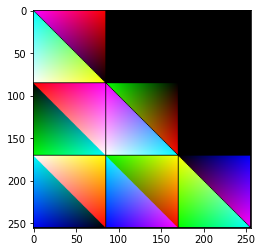

In [181]:
plt.imshow(texture_im)

In [135]:
def red_top(x):
    output = np.zeros((x.shape[0], 3))
    output[x[:, 0] > 0.0] = [1.0, 0.0, 0.0]
    output[x[:, 0] <= 0.0] = [0.0, 0.0, 1.0]

    return output

In [182]:
cv2.imwrite(
    "tex_im.png", 
    cv2.cvtColor((texture_im * 255).astype(np.uint8), cv2.COLOR_RGB2BGR),
)

True